In [1]:
import sys
sys.path.append('../')  

from data.dummy_datasets import create_cube
from utils.operations import E2G
from models.gnca import GNCAModel
from utils.plots import *
from utils.operations import *
import torch
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
from tqdm import tqdm
import matplotlib.animation as animation

In [2]:
EPOCHS = 4000

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gnca = GNCAModel(input_dim=4, channel_n=2, fire_rate=0.5, device=device)
optimizerG = optim.Adam(gnca.parameters(), lr=2e-3)
# torch.nn.utils.clip_grad_norm_(gnca.parameters(), max_norm=1.0) # gradient clipping

In [4]:
coords, E = create_cube(3, 1)
G = E2G(E, 27)
adj = nx.adjacency_matrix(G).toarray()
x = np.zeros(coords.shape[0])
x[coords.shape[0] // 2] = 1
x_ = np.zeros(coords.shape[0])
x = np.stack((x, x_), axis=-1)
target = np.ones(coords.shape[0])

adj = torch.tensor(adj, dtype=torch.float32).to(device)
x = torch.tensor(x, dtype=torch.float32).to(device)
target = torch.tensor(target, dtype=torch.float32).to(device)

<Axes3D: title={'center': 'target'}>

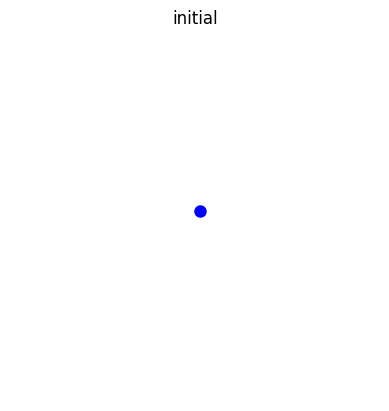

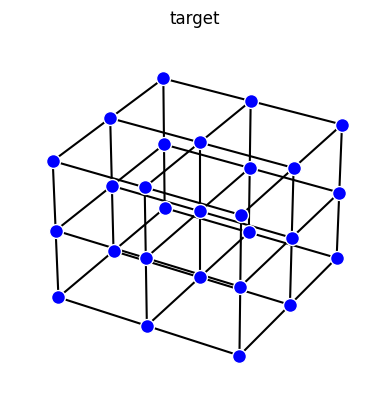

In [5]:
plot_3d_G(G, coords, "initial", transparent=True, show_edges=True, angle=30, node_alpha=x[:, 0].to('cpu').detach().numpy())
plot_3d_G(G, coords, "target", transparent=True, show_edges=True, angle=30, node_alpha=target.to('cpu').detach().numpy())

Training

In [6]:
def loss_f(yhat, y):
    return F.mse_loss(yhat, y)

alphas = []

# Training loop
with tqdm(total=EPOCHS, desc="Training Progress") as pbar:
    for epoch in range(EPOCHS):
        
        adj = adj.detach()
        x = x.detach()

        gnca.train()
        
        x = gnca(x, adj)  
        
        loss = loss_f(x[:, 0], target)
        
        optimizerG.zero_grad()
        loss.backward()

        # Gradient clipping
        for param in gnca.parameters():
            if param.grad is not None:
                param.grad.data /= (torch.norm(param.grad.data) + 1e-8)

        optimizerG.step()

        if (epoch % 10 == 0):
            alphas.append(x[:, 0].to('cpu').detach().numpy())

        # Update progress bar description
        pbar.set_postfix({'Loss': loss.item()})
        pbar.update(1)  # Move progress bar forward

Training Progress: 100%|██████████| 4000/4000 [00:19<00:00, 202.23it/s, Loss=1] 


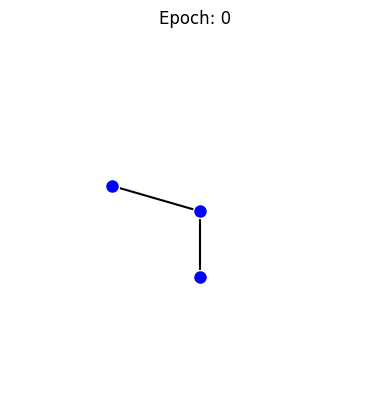

In [7]:
# Create the figure and 3D axis
fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111, projection='3d')


# Define the update function for the animation
def update(i):
    ax.clear() 
    node_alpha = np.clip(alphas[i], 0, 1)
    plot_3d_G(G, coords, "cube G", transparent=True, show_edges=True, angle=30, node_alpha=node_alpha, ax=ax)
    ax.set_title(f"Epoch: {i*10}")
    return ax,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(alphas), interval=100, repeat=False)

ani.save('life.gif', dpi=300, writer=animation.PillowWriter(fps=10))